# IREI: Profile-based retrieval
### Víctor Morcuende Castell and Guillermo Nájera Lavid
#### Course 2022-2023

### Preprocessing Phase

In [1]:
import nltk

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /Users/victor/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/victor/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/victor/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/victor/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/victor/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to
[nltk_data]

True

In [2]:
# Read the data
import pandas as pd

data = pd.read_csv('dataset/BBC News Train.csv')

# Remove duplicated data
data = data.drop_duplicates(subset=['Text','Category'])
data.head(10)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
5,1582,howard truanted to play snooker conservative...,politics
6,651,wales silent on grand slam talk rhys williams ...,sport
7,1797,french honour for director parker british film...,entertainment
8,2034,car giant hit by mercedes slump a slump in pro...,business
9,1866,fockers fuel festive film chart comedy meet th...,entertainment


In [3]:
data.shape

(1440, 3)

In [4]:
data.groupby(['Category']).size().sort_values(ascending=True)

Category
tech             234
entertainment    263
politics         266
business         335
sport            342
dtype: int64

<Axes: ylabel='Category'>

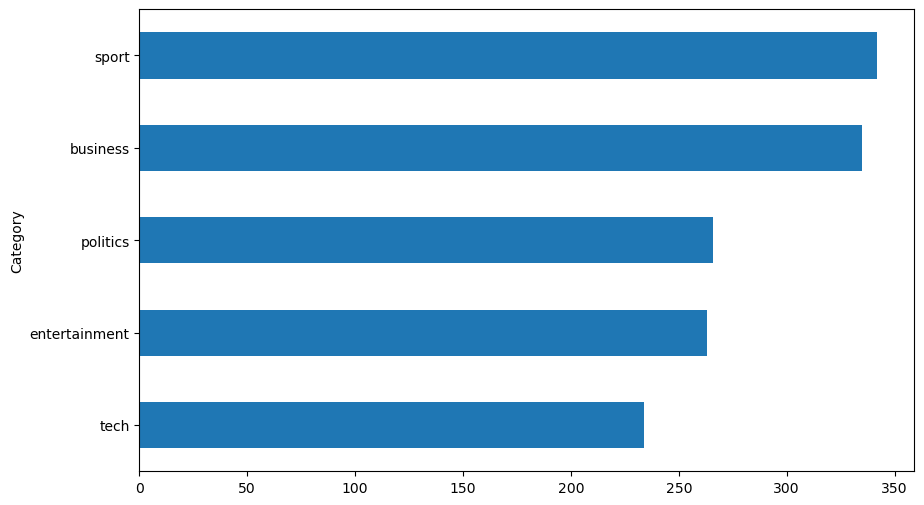

In [5]:
data.groupby(['Category']).size().sort_values(ascending=True).plot(kind='barh', figsize=(10, 6))

In [6]:
# Remove all punctuations from the text
import string as st

def remove_punct(text):
    return ("".join([ch for ch in text if ch not in st.punctuation]))

data['removed_punc'] = data['Text'].apply(lambda x: remove_punct(x))
data.head()

,ArticleId,Text,Category,removed_punc
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...


In [7]:
# Convert text to lower case tokens
import re

def tokenize(text):
    text = re.split('\s+' ,text)
    return [x.lower() for x in text]

data['tokens'] = data['removed_punc'].apply(lambda msg : tokenize(msg))
data.head()

,ArticleId,Text,Category,removed_punc,tokens
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,..."
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize..."
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo..."


In [8]:
# Remove tokens of length less than 3
def remove_small_words(text):
    return [x for x in text if len(x) > 3 ]

data['larger_tokens'] = data['tokens'].apply(lambda x : remove_small_words(x))
data.head()

,ArticleId,Text,Category,removed_punc,tokens,larger_tokens
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,..."
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize...","[poll, indicates, economic, gloom, citizens, m..."
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo...","[enron, bosses, 168m, payout, eighteen, former..."


In [9]:
# Remove stopwords by using NLTK corpus list
def remove_stopwords(text):
    return [word for word in text if word not in nltk.corpus.stopwords.words('english')]

data['clean_tokens'] = data['larger_tokens'].apply(lambda x : remove_stopwords(x))
data.head()

,ArticleId,Text,Category,removed_punc,tokens,larger_tokens,clean_tokens
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,..."
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize...","[poll, indicates, economic, gloom, citizens, m...","[poll, indicates, economic, gloom, citizens, m..."
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo...","[enron, bosses, 168m, payout, eighteen, former...","[enron, bosses, 168m, payout, eighteen, former..."


In [10]:
# Apply lemmatization on tokens
from nltk import WordNetLemmatizer

def lemmatize(text):
    word_net = WordNetLemmatizer()
    return [word_net.lemmatize(word) for word in text]

data['lemma_words'] = data['clean_tokens'].apply(lambda x : lemmatize(x))
data.head()

,ArticleId,Text,Category,removed_punc,tokens,larger_tokens,clean_tokens,lemma_words
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launch, defence, lawyer, de..."
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slide, german, ..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize...","[poll, indicates, economic, gloom, citizens, m...","[poll, indicates, economic, gloom, citizens, m...","[poll, indicates, economic, gloom, citizen, ma..."
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo...","[enron, bosses, 168m, payout, eighteen, former...","[enron, bosses, 168m, payout, eighteen, former...","[enron, boss, 168m, payout, eighteen, former, ..."


In [11]:
# Create sentences to get clean text as input for vectors
def return_sentences(tokens):
    return " ".join([word for word in tokens])

data['clean_text'] = data['lemma_words'].apply(lambda x : return_sentences(x))
data.head()

,ArticleId,Text,Category,removed_punc,tokens,larger_tokens,clean_tokens,lemma_words,clean_text
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launch, defence, lawyer, de...",worldcom exboss launch defence lawyer defendin...
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slide, german, ...",german business confidence slide german busine...
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize...","[poll, indicates, economic, gloom, citizens, m...","[poll, indicates, economic, gloom, citizens, m...","[poll, indicates, economic, gloom, citizen, ma...",poll indicates economic gloom citizen majority...
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...",lifestyle governs mobile choice faster better ...
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo...","[enron, bosses, 168m, payout, eighteen, former...","[enron, bosses, 168m, payout, eighteen, former...","[enron, boss, 168m, payout, eighteen, former, ...",enron boss 168m payout eighteen former enron d...


### Profile's Creation and Documents' Encoding

In [12]:
# Balancing the dataset to have the same number of documents for each query
from sklearn.utils import resample

def balance_data(data, category_col):
    categories = data[category_col].unique()
    min_category_count = data[category_col].value_counts().min()

    balanced_data = []

    for category in categories:
        category_data = data[data[category_col] == category]
        category_data_balanced = resample(category_data, replace=False, n_samples=min_category_count, random_state=42)
        balanced_data.append(category_data_balanced)

    return pd.concat(balanced_data)

In [13]:
data = balance_data(data, 'Category')
balanced_data = data[['clean_text', 'Category']]
balanced_data.groupby(['Category']).size().sort_values(ascending=True)

Category
business         234
entertainment    234
politics         234
sport            234
tech             234
dtype: int64

<Axes: ylabel='Category'>

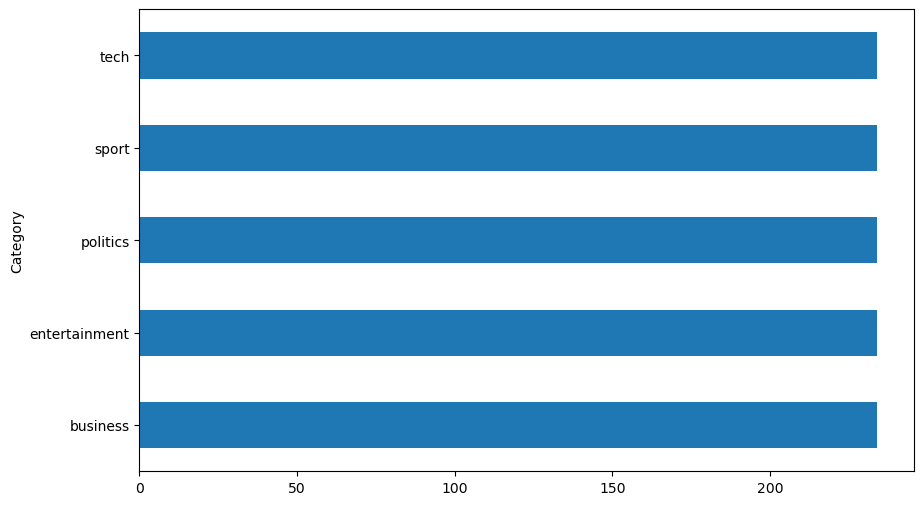

In [14]:
balanced_data.groupby(['Category']).size().sort_values(ascending=True).plot(kind='barh', figsize=(10, 6))

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
documents_vec = vectorizer.fit_transform(balanced_data['clean_text'])

In [16]:
topics = {
    # Sport
    'sport': ['sport', 'match', 'champion', 'play', 'injury', 'team', 'chelsea', 'season',
              'side', 'second', 'final', 'club', 'rugby', 'coach', 'united', 'arsenal',
              'nation', 'robinson', 'great', 'start', 'international', 'league', 'victory',
              'well', 'olympic', 'chance', 'race', 'minute', 'played', 'australian', 'best',
              'mourinho', 'roddick', 'championship', 'point', 'event', 'title', 'referee',
              'goal', 'beat', 'liverpool', 'grand', 'test', 'manager', 'ball', 'place', 'woman',
              'winning', 'tennis', 'squad'],
    
    # Business
    'business': ['business', 'year', 'firm', 'company', 'rate', 'economy', 'growth', 'sale', 
                 'market', 'bank', 'price', 'share', 'dollar', 'economic', 'country', 'government',
                 'month', 'profit', 'figure', 'business', 'deal', 'euro', 'world', 'analyst',
                 'trade', 'rise', 'offer', 'deficit', 'report', 'chief', 'spending', 'time',
                 'quarter', 'financial', 'stock', 'consumer', 'high', 'executive', 'export',
                 'investment', 'demand', 'cost', 'interest', 'job', 'shareholder', 'european',
                 'fall', 'deutsche', 'worldcom', 'investor'],
                 
    # Entertainment
    'entertainment': ['entertainment', 'film', 'award', 'band', 'actor', 'star', 'album', 'oscar',
                      'festival', 'director', 'song', 'single', 'actress', 'record', 'singer',
                      'nomination', 'movie', 'book', 'musical', 'comedy', 'role', 'prize', 'theatre',
                      'series', 'winner', 'rock', 'life', 'producer', 'five', 'ceremony', 'aviator',
                      'hollywood', 'academy', 'category', 'audience', 'performance', 'drama',
                      'starring', 'love', 'christmas', 'release', 'nominated', 'radio', 'studio',
                      'television', 'foxx', 'success', 'industry', 'live', 'stage'],
    
    # Politics
    'politics': ['politics', 'labour', 'election', 'party', 'blair', 'tory', 'lord', 'minister',
                 'plan', 'bill', 'britain', 'prime', 'leader', 'chancellor', 'public', 'kennedy',
                 'campaign', 'police', 'issue', 'general', 'secretary', 'vote', 'conservative',
                 'council', 'right', 'school', 'liberal', 'spokesman', 'change', 'power', 'house',
                 'democrat', 'claim', 'budget', 'local', 'court', 'voter', 'immigration', 'policy',
                 'member', 'tax', 'card', 'union', 'case', 'foreign', 'seat', 'political', 'poll', 
                 'part', 'back'],
    
    # Tech
    'tech': ['tech', 'technology', 'mobile', 'phone', 'game', 'service', 'technology', 'software',
             'broadband', 'user', 'microsoft', 'search', 'computer', 'gadget', 'site', 'virus', 'network',
             'digital', 'system', 'email', 'online', 'player', 'security', 'machine', 'internet',
             'program', 'device', 'video', 'blog', 'data', 'information', 'sony', 'medium', 'website',
             'content', 'message', 'apple', 'console', 'camera', 'google', 'research', 'attack',
             'nintendo', 'customer', 'version', 'gaming', 'window', 'speed', 'file', 'spam']
}

In [17]:
profiles = [
    {'id': 1, 'interests': topics['sport']},
    {'id': 2, 'interests': topics['business']},
    {'id': 3, 'interests': topics['entertainment']},
    {'id': 4, 'interests': topics['politics']},
    {'id': 5, 'interests': topics['tech']},
    {'id': 6, 'interests': topics['sport'] + topics['business']},
    {'id': 7, 'interests': topics['entertainment'] + topics['politics']},
    {'id': 8, 'interests': topics['tech'] + topics['sport']},
    {'id': 9, 'interests': topics['business'] + topics['entertainment']},
    {'id': 10, 'interests': topics['politics'] + topics['tech'] + topics['business']}
]

#### Creating the profiles by using the Weighted Topic Frequency (WTF) method

This a creative approach for constructing profile vectors that takes into account the uniqueness of each topic for the profile.

1. Calculate the term frequency (TF) for each word in the profile's interests.
2. Calculate the inverse topic frequency (ITF) for each word across all topics.
3. Calculate the Weighted Topic Frequency (WTF) for each word by multiplying its TF by its ITF.
4. Create the profile vector by using the WTF values for each word in the profile's interests.

Here's a step-by-step explanation:

1. Term Frequency (TF): Count the frequency of each word in the profile's interests and normalize it by the total number of words in the profile's interests.

2. Inverse Topic Frequency (ITF): For each word in the profile's interests, calculate its presence in all topics. Then, compute the inverse of this presence (total number of topics / number of topics containing the word). This will give higher weights to words that are more unique to a profile's interests.

3. Weighted Topic Frequency (WTF): Multiply the TF and ITF for each word to obtain the WTF value. This will emphasize words that are both frequent in the profile's interests and unique to their topics.

4. Profile vector creation: Use the WTF values for each word in the profile's interests to create the profile vector. This can be done by transforming the profile's interests (with WTF values) using the vectorizer.transform() function.

In [18]:
import numpy as np
from collections import Counter

def calculate_tf(profile_interests):
    word_count = Counter(profile_interests)
    total_words = len(profile_interests)
    tf = {word: count / total_words for word, count in word_count.items()}
    return tf

def calculate_itf(profile_interests, topics):
    num_topics = len(topics)
    topic_presence = {word: 0 for word in profile_interests}
    
    for topic_words in topics.values():
        for word in set(profile_interests):
            if word in topic_words:
                topic_presence[word] += 1
    
    itf = {word: np.log(num_topics / presence) for word, presence in topic_presence.items()}
    return itf

def calculate_wtf(profile_interests, topics):
    tf = calculate_tf(profile_interests)
    itf = calculate_itf(profile_interests, topics)
    wtf = {word: tf[word] * itf[word] for word in profile_interests}
    return wtf

profiles_vec = []
for profile in profiles:
    wtf = calculate_wtf(profile['interests'], topics)
    weighted_interests = " ".join([word for word, weight in wtf.items() for _ in range(int(weight * 100))])
    profile_vec = vectorizer.transform([weighted_interests])
    profiles_vec.append(profile_vec)

profiles_list = [profiles_vec[i] for i in range(len(profiles_vec))]

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to find the top n matches for a profile
def find_top_n_matches(profile_vec, documents_vec, n):
    similarities = cosine_similarity(profile_vec, documents_vec)
    sorted_indices = np.argsort(similarities[0])[::-1]
    return sorted_indices[:n]

# Calculate the top n matches for each profile
n = 5
recommended_documents = []

for profile_vec in profiles_vec:
    top_n_indices = find_top_n_matches(profile_vec, documents_vec, n)
    recommended_documents.append(top_n_indices)

### System Evaluation

In [20]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, average_precision_score, coverage_error

# Create binary classifiers for each category
categories = list(topics.keys())
category_classifiers = {category: (documents_vec, (balanced_data['Category'] == category).astype(int)) for category in categories}

# Calculate metrics for each profile
all_true_labels = []
all_predicted_scores = []

print("Profile Interests and Predicted Categories:")
for profile, top_n_indices in zip(profiles, recommended_documents):
    true_labels = [1 if interest in profile['interests'] else 0 for interest in categories]
    predicted_scores = []

    for category in categories:
        classifier_data, category_labels = category_classifiers[category]
        match_count = 0

        for idx in top_n_indices:
            predicted_label = category_labels.iloc[idx]
            if predicted_label == 1:
                match_count += 1

        predicted_scores.append(match_count / n)

    print("\nProfile ID:", profile["id"])
    print("Interests:", ', '.join(profile["interests"]))
    print("Predicted Categories:")
    for idx, category in enumerate(categories):
        print(f"{category}: {predicted_scores[idx]:.2f}")

    all_true_labels.append(true_labels)
    all_predicted_scores.append(predicted_scores)

all_true_labels = np.array(all_true_labels)
all_predicted_scores = np.array(all_predicted_scores)

# Calculate the number of correctly predicted samples
correct_predictions = accuracy_score(all_true_labels, np.round(all_predicted_scores), normalize=False)

# Calculate the total number of samples
total_samples = all_true_labels.shape[0]

# Calculate the accuracy
accuracy = correct_predictions / total_samples

# Calculate average precision and coverage
average_precision = average_precision_score(all_true_labels, all_predicted_scores)
coverage = coverage_error(all_true_labels, all_predicted_scores)

# Calculate recall for multi-label classification
recall = recall_score(all_true_labels, np.round(all_predicted_scores), average='samples')

# Calculate F1-score for multi-label classification
f1_measure = f1_score(all_true_labels, np.round(all_predicted_scores), average='samples')

# Calculate AU-ROC for multi-label classification
au_roc = roc_auc_score(all_true_labels, all_predicted_scores, average='samples')


print("\nEvaluation Metrics:")
print("Accuracy: ", accuracy)
print("Precision: ", average_precision)
print("Recall: ", recall)
print("F1-Measure: ", f1_measure)
print("AU-ROC: ", au_roc)
print("Coverage Error: ", coverage)

Profile Interests and Predicted Categories:

Profile ID: 1
Interests: sport, match, champion, play, injury, team, chelsea, season, side, second, final, club, rugby, coach, united, arsenal, nation, robinson, great, start, international, league, victory, well, olympic, chance, race, minute, played, australian, best, mourinho, roddick, championship, point, event, title, referee, goal, beat, liverpool, grand, test, manager, ball, place, woman, winning, tennis, squad
Predicted Categories:
sport: 1.00
business: 0.00
entertainment: 0.00
politics: 0.00
tech: 0.00

Profile ID: 2
Interests: business, year, firm, company, rate, economy, growth, sale, market, bank, price, share, dollar, economic, country, government, month, profit, figure, business, deal, euro, world, analyst, trade, rise, offer, deficit, report, chief, spending, time, quarter, financial, stock, consumer, high, executive, export, investment, demand, cost, interest, job, shareholder, european, fall, deutsche, worldcom, investor
Pre

In [21]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

# Round the predicted scores to the nearest integer (0 or 1)
rounded_predicted_labels = np.round(all_predicted_scores)

# Calculate classification report and confusion matrix
class_report = classification_report(all_true_labels, rounded_predicted_labels, target_names=categories, zero_division=0)
conf_matrix = multilabel_confusion_matrix(all_true_labels, rounded_predicted_labels)

print("Classification Report:\n", class_report)
print("Confusion Matrix:\n")

for i, category in enumerate(categories):
    print(f"{category}:\n")
    print(conf_matrix[i])
    print()


Classification Report:
                precision    recall  f1-score   support

        sport       1.00      0.33      0.50         3
     business       1.00      0.50      0.67         4
entertainment       1.00      0.67      0.80         3
     politics       1.00      1.00      1.00         3
         tech       1.00      0.67      0.80         3

    micro avg       1.00      0.62      0.77        16
    macro avg       1.00      0.63      0.75        16
 weighted avg       1.00      0.62      0.75        16
  samples avg       1.00      0.73      0.82        16

Confusion Matrix:

sport:

[[7 0]
 [2 1]]

business:

[[6 0]
 [2 2]]

entertainment:

[[7 0]
 [1 2]]

politics:

[[7 0]
 [0 3]]

tech:

[[7 0]
 [1 2]]



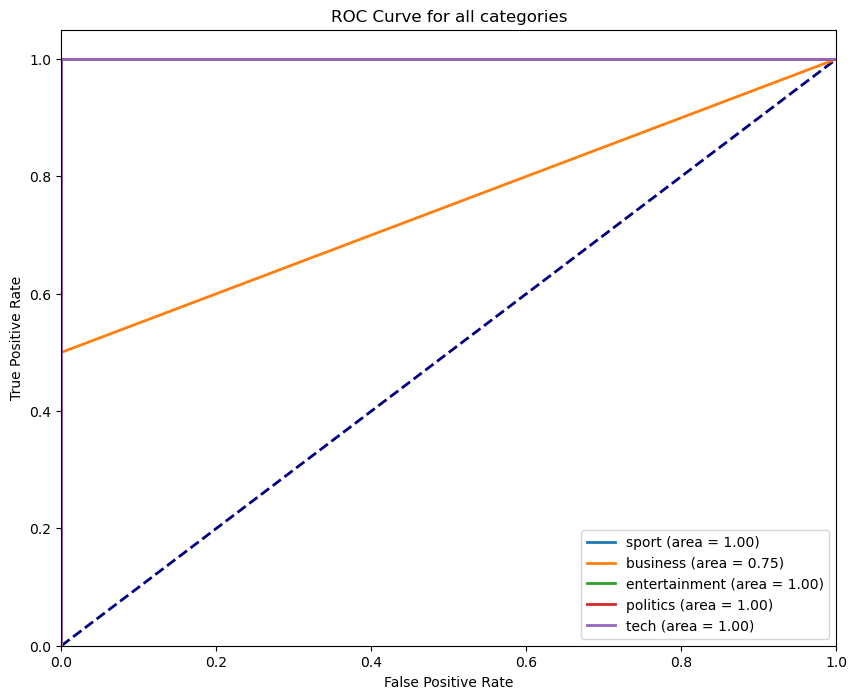

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to plot ROC curve for each category
def plot_roc_curve(true_labels, predicted_labels, category, ax):
    fpr, tpr, _ = roc_curve(true_labels, predicted_labels)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr,
             lw=2, label=f'{category} (area = {roc_auc:.2f})')
    
# Set up the figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for all categories')

# Plot ROC curve for each category
for category in categories:
    true_labels = all_true_labels[:, categories.index(category)]
    predicted_scores = all_predicted_scores[:, categories.index(category)]
    plot_roc_curve(true_labels, predicted_scores, category, ax)

ax.legend(loc="lower right")
plt.show()


### Model Creation Phase

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(balanced_data['clean_text'], balanced_data['Category'], test_size=0.2, random_state=42)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [24]:
from sklearn.metrics import confusion_matrix

def train_and_evaluate(classifier, X_train_vec, y_train, X_test_vec, y_test):
    classifier.fit(X_train_vec, y_train)
    y_pred = classifier.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    classification_report_dict = classification_report(y_test, y_pred, output_dict=True)
    
    print(classifier.__class__.__name__)
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n")
    
    performance = {
        "accuracy": accuracy,
        "precision": classification_report_dict["macro avg"]["precision"],
        "recall": classification_report_dict["macro avg"]["recall"],
        "f1_score": classification_report_dict["macro avg"]["f1-score"],
    }
    
    return performance

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

performance_metrics = {}

classifiers = [
    MultinomialNB(),
    LogisticRegression(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier()
]


for classifier in classifiers:
    performance_metrics[classifier.__class__.__name__] = train_and_evaluate(classifier, X_train_vec, y_train, X_test_vec, y_test)

MultinomialNB
Accuracy: 0.9743589743589743
Classification Report:
                precision    recall  f1-score   support

     business       0.98      0.96      0.97        45
entertainment       0.97      0.97      0.97        38
     politics       0.94      0.96      0.95        49
        sport       0.98      1.00      0.99        52
         tech       1.00      0.98      0.99        50

     accuracy                           0.97       234
    macro avg       0.97      0.97      0.97       234
 weighted avg       0.97      0.97      0.97       234

Confusion Matrix:
 [[43  0  2  0  0]
 [ 0 37  1  0  0]
 [ 1  1 47  0  0]
 [ 0  0  0 52  0]
 [ 0  0  0  1 49]]


LogisticRegression
Accuracy: 0.9529914529914529
Classification Report:
                precision    recall  f1-score   support

     business       0.96      0.96      0.96        45
entertainment       0.93      0.97      0.95        38
     politics       0.96      0.92      0.94        49
        sport       0.93      

In [26]:
for classifier, metrics in performance_metrics.items():
    print(f"{classifier}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")
    print("\n")

MultinomialNB:
  accuracy: 0.9744
  precision: 0.9744
  recall: 0.9737
  f1_score: 0.9740


LogisticRegression:
  accuracy: 0.9530
  precision: 0.9533
  recall: 0.9535
  f1_score: 0.9526


LinearSVC:
  accuracy: 0.9615
  precision: 0.9611
  recall: 0.9620
  f1_score: 0.9611


RandomForestClassifier:
  accuracy: 0.9615
  precision: 0.9632
  recall: 0.9603
  f1_score: 0.9615


KNeighborsClassifier:
  accuracy: 0.9145
  precision: 0.9149
  recall: 0.9148
  f1_score: 0.9133




In [27]:
from sklearn.model_selection import cross_val_score

def evaluate_with_cross_val(classifier, X, y, n_splits=5):
    scores = cross_val_score(classifier, X, y, cv=n_splits)
    return np.mean(scores)

X_vec = vectorizer.fit_transform(data['clean_text'])
y = data['Category']

for classifier in classifiers:
    mean_score = evaluate_with_cross_val(classifier, X_vec, y)
    print(f"{classifier.__class__.__name__}: {mean_score:.4f}")

MultinomialNB: 0.9650
LogisticRegression: 0.9641
LinearSVC: 0.9624
RandomForestClassifier: 0.9462
KNeighborsClassifier: 0.9162


Confusion Matrix for MultinomialNB:


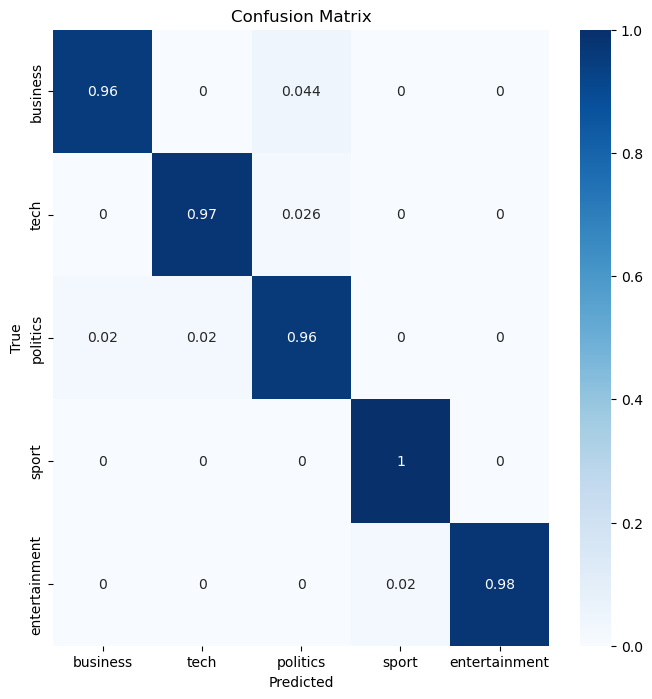

Confusion Matrix for LogisticRegression:


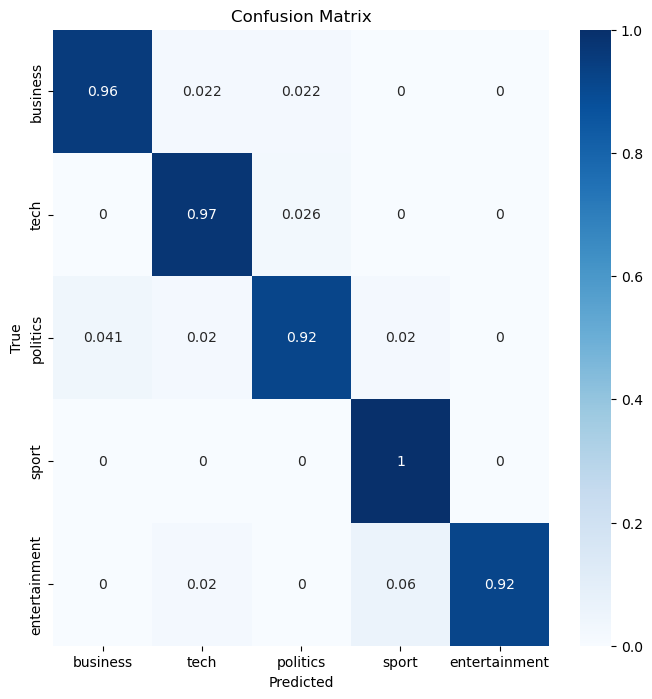

Confusion Matrix for LinearSVC:


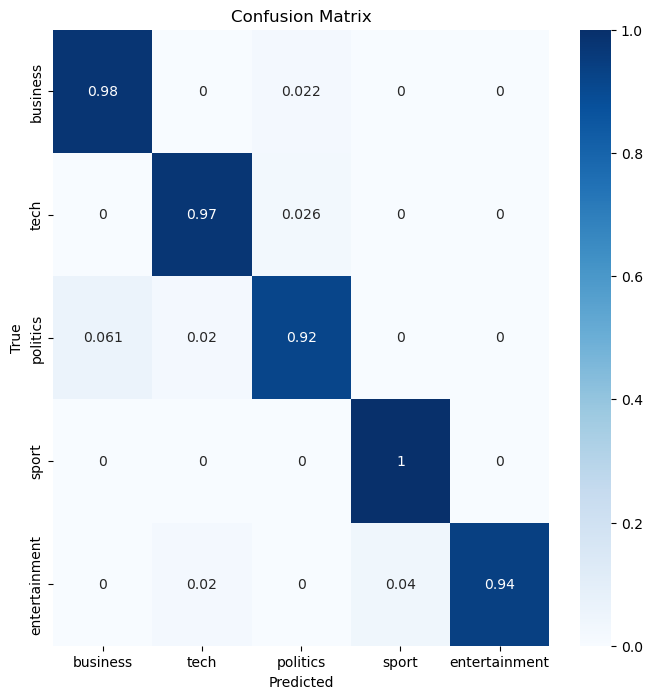

Confusion Matrix for RandomForestClassifier:


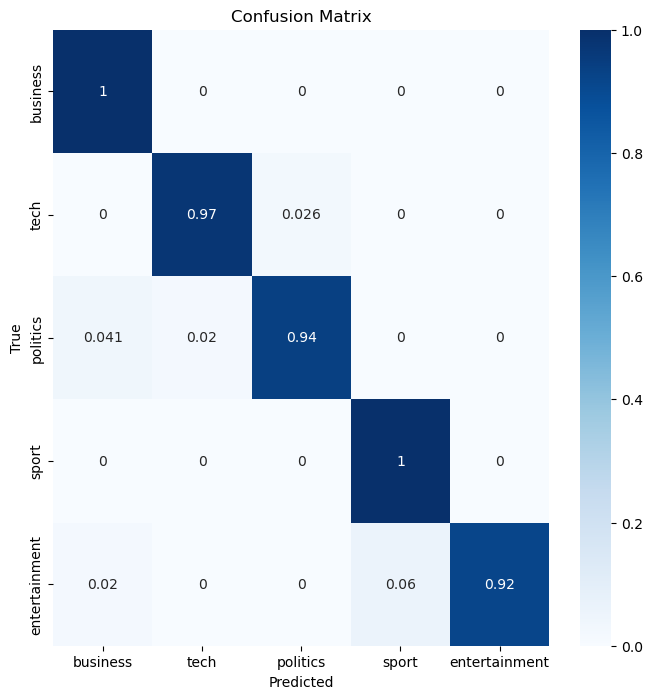

Confusion Matrix for KNeighborsClassifier:


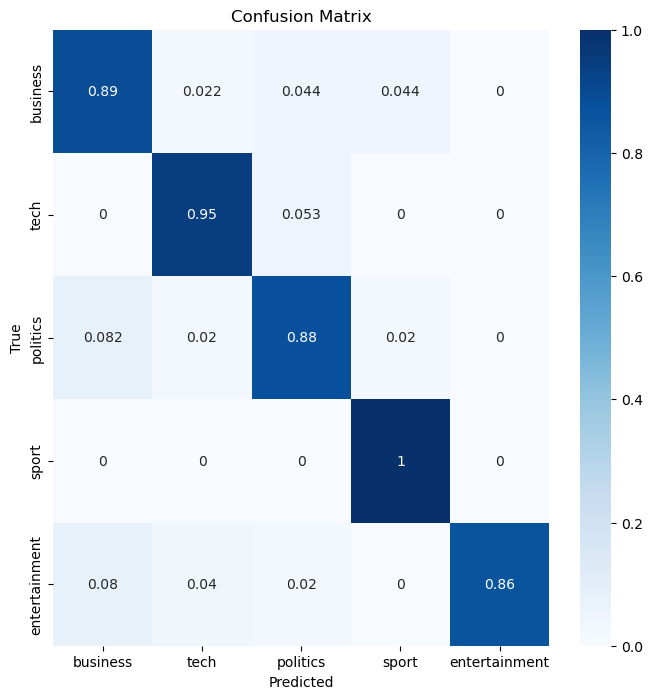

In [28]:
import seaborn as sns

def plot_cm(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_names = data['Category'].unique()

for classifier in classifiers:
    classifier.fit(X_train_vec, y_train)
    y_pred = classifier.predict(X_test_vec)
    print(f"Confusion Matrix for {classifier.__class__.__name__}:")
    plot_cm(y_test, y_pred, class_names)